Here I will explore the basics of handling and cropping the large csv file. Hopefully this can be optimized!!!

In [32]:
import dask.dataframe as dd

import sys
sys.path.append("../")

import pandas as pd

import os

import matplotlib.pyplot as plt

In [7]:
folder = "../Data/25_3_data_getting/"

The basic oresund filtering takes only 1 min/day! (copared to 9 mins in pandas!)

In [11]:
fname = "aisdk-2025-03-24.parquet"
#loading csv
df = dd.read_csv("../Data/25_3_data_getting/aisdk-2025-03-24.csv", dtype={'Cargo type': 'str', 'ETA': 'str'})

#Oresund region
nswe = [56.110689, 55.369532, 12.137468, 13.120240]

df = df[(df['Latitude'] < nswe[0]) & (df['Latitude'] > nswe[1]) & (df['Longitude'] > nswe[2]) & (df['Longitude'] < nswe[3])]
df.to_parquet(folder+fname, engine='pyarrow', write_index=False)

Now trying different approach (because dataset is smaller than memory when oresund is filtered I can do computations in pandas!)

In [ ]:
df = dd.read_csv("../Data/25_3_data_getting/aisdk-2025-03-24.csv", dtype={'Cargo type': 'str', 'ETA': 'str'})

#Oresund region
nswe = [56.110689, 55.369532, 12.137468, 13.120240]

df = df[(df['Latitude'] < nswe[0]) & (df['Latitude'] > nswe[1]) & (df['Longitude'] > nswe[2]) & (df['Longitude'] < nswe[3])]
df = df.compute() #Loads the data into memory as a pandas dataframe. Efficient now!
print('Computed')

df.drop_duplicates()
data_temp = pd.DataFrame(columns=df.columns)

for MMSI in df['MMSI'].unique():
    ship = df[df['MMSI'] == MMSI]
    #Creating a series for time filtering
    series = pd.Series(range(len(ship)), index=pd.to_datetime(ship['# Timestamp'], dayfirst=True))
    #Resampling the series to 5 minutes. This gives the index of the last data point in the 5 minute interval
    #The unique is added because if transmission occurs less frequently than 5 mins there will be duplicates
    resampled = series.resample('5min').first().dropna().astype(int)
    #Filtering the data
    ship = ship.iloc[resampled]
    data_temp = pd.concat([data_temp, ship], ignore_index=True)

df = data_temp.copy()

#And down here will go all the other filtering steps!!!

Computed


/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_5410/3787796275.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_temp = pd.concat([data_temp, ship], ignore_index=True)
/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_5410/3787796275.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_temp = pd.concat([data_temp, ship], ignore_index=True)


In [ ]:
#Saving as single ships!
#Parquet files loads columns extremely fast, so no problem if not all of them are used in data analysis!
folder_n = folder + 'Ships/'

for MMSI in df['MMSI'].unique():
    ship = df[df['MMSI'] == MMSI]
    ship.to_parquet(folder_n + str(MMSI) + ".parquet", engine='pyarrow', index=False)

df.to_parquet(folder + fname, engine='pyarrow', index=False)

Trying to see if I can concatenate ships into single files!

In [19]:
folder = "../Data/"
fname = "aisdk-2025-01-19.csv"
#loading csv
df = dd.read_csv(folder + fname, dtype={'Cargo type': 'str', 'ETA': 'str', 'Name': 'str'})

#Oresund region
nswe = [56.110689, 55.369532, 12.137468, 13.120240]

df = df[(df['Latitude'] < nswe[0]) & (df['Latitude'] > nswe[1]) & (df['Longitude'] > nswe[2]) & (df['Longitude'] < nswe[3])]
df = df.compute() #Loads the data into memory as a pandas dataframe. Efficient now!
print('Computed')

df.drop_duplicates()
data_temp = pd.DataFrame(columns=df.columns)

for MMSI in df['MMSI'].unique():
    ship = df[df['MMSI'] == MMSI]
    #Creating a series for time filtering
    series = pd.Series(range(len(ship)), index=pd.to_datetime(ship['# Timestamp'], dayfirst=True))
    #Resampling the series to 5 minutes. This gives the index of the last data point in the 5 minute interval
    #The unique is added because if transmission occurs less frequently than 5 mins there will be duplicates
    resampled = series.resample('5min').first().dropna().astype(int)
    #Filtering the data
    ship = ship.iloc[resampled]
    data_temp = pd.concat([data_temp, ship], ignore_index=True)

df = data_temp.copy()

#And down here will go all the other filtering steps!!!

Computed


/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_5410/2435935422.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_temp = pd.concat([data_temp, ship], ignore_index=True)
/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_5410/2435935422.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_temp = pd.concat([data_temp, ship], ignore_index=True)


In [30]:
folder_load = "../Data/25_3_data_getting/Ships/"
folder_save = "../Data/25_3_data_getting/New_ships/"

existing_ships = set()
for ship in os.listdir(folder_load):
    existing_ships.add(int(ship.split('.')[0]))

i = 0
for MMSI in df['MMSI'].unique():
    if MMSI in existing_ships:
        i += 1

print(i)

for MMSI in df['MMSI'].unique():
    ship = df[df['MMSI'] == MMSI]
    if MMSI not in existing_ships:
        ship.to_parquet(folder_save + str(MMSI) + ".parquet", engine='pyarrow', index=False)
        existing_ships.add(MMSI)

        
    else:
        ship_old = pd.read_parquet(folder_load + str(MMSI) + ".parquet", engine='pyarrow')
        ship = pd.concat([ship_old, ship], ignore_index=True)
        ship.to_parquet(folder_save + str(MMSI) + ".parquet", engine='pyarrow', index=False)
        print(MMSI)

#This doesn't copy the all the old ships but whatever. It is testing
        

198
265572330
219006221
219000368
2655140
219230000
2190047
219014974
265514800
219030094
219001819
219024402
219001619
219027309
219001214
219026000
219002798
219020533
219007898
219003452
219018032
219032359
265041000
219001362
265952000
219007572
265797590
265768860
219024176
211787120
219002801
219024177
219005904
265610950
219000575
265011730
265522730
219622000
265504660
219029444
265524530


/var/folders/29/jqsnm5js6_sc7663vjsq3mp40000gp/T/ipykernel_5410/3658902287.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ship = pd.concat([ship_old, ship], ignore_index=True)


219024675
219029886
219006564
265649310
219006008
219014538
219022389
219022390
219022736
219004634
219007693
219011448
219031690
219006078
265698740
219029348
219023018
219025371
219026305
219000675
219026301
219030294
265516080
265594380
265768840
265667170
219022282
265756000
219025446
244153423
219032257
219031192
219006387
219001306
219012277
265591210
266475000
265628170
219001063
232050936
219025528
219009657
219030424
219000551
992651010
992651016
219024144
992651006
265793620
219026300
219005252
992651011
219018733
265828130
219000182
219026391
265712190
219006006
219030580
219026304
219029637
219026079
219027249
219022668
219021504
219028120
220476000
219009871
219027576
219027899
219003461
265788680
244750462
219001375
219033674
314218000
219026071
219033884
219017202
219024777
219000174
265527020
265526690
219000217
219016663
219002846
265182000
219019441
265807560
219004695
265023550
219029210
219005574
219016692
219030561
265621730
219028507
219007035
265719650
219003121


In [ ]:
MMSI = 265649310

old = pd.read_parquet(folder_load + str(MMSI) + ".parquet", engine='pyarrow', columns = ['Latitude'])
new = pd.read_parquet(folder_save + str(MMSI) + ".parquet", engine='pyarrow', columns = ['Latitude'])

len(old), len(new)


(151, 357)

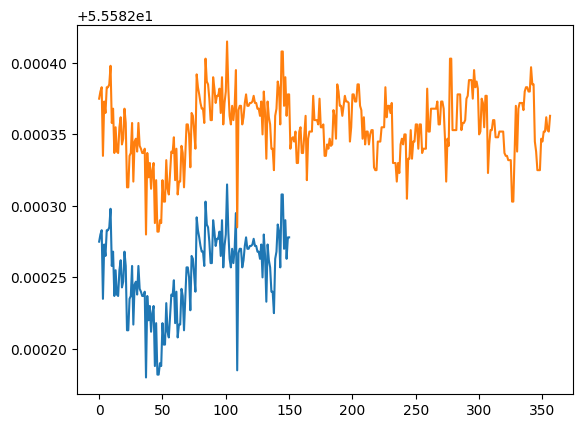

In [37]:
plt.plot(old['Latitude'], label='Old')
plt.plot(new['Latitude'] + 0.0001, label='New')